In [54]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

import sklearn
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.decomposition import PCA

from scipy.stats import pearsonr

from scipy.stats import entropy

In [2]:
path = "/home/koki/Desktop/Data/OutOfStock/preprocessed.csv"
df = pd.read_csv(path)

In [3]:
df.head()

,Zulassungsinhaber,wirkstoff,Beginn,Ende,days,months,years
0,AstraZeneca GmbH,['Goserelinacetat'],2021-11-11,2022-01-24,74,"Counter({'Nov': 1, 'Dec': 1, 'Jan': 1})","{'2021': 60, '2022': 30}"
1,Hexal Aktiengesellschaft,['Octreotidacetat'],2021-09-03,2022-01-29,148,"Counter({'Sep': 1, 'Oct': 1, 'Nov': 1, 'Dec': ...","{'2021': 121, '2022': 30}"
2,Hexal Aktiengesellschaft,['Octreotidacetat'],2021-10-29,2022-01-29,92,"Counter({'Oct': 1, 'Nov': 1, 'Dec': 1, 'Jan': 1})","{'2021': 91, '2022': 30}"
3,Leo Pharma A/S Beiname: Leo Pharmaceutical Pro...,['Natriumfusidat'],2021-10-11,2021-12-14,64,"Counter({'Oct': 1, 'Nov': 1, 'Dec': 1})",{'2021': 91}
4,Leo Pharma A/S Beiname: Leo Pharmaceutical Pro...,['Natriumfusidat'],2021-10-18,2021-10-19,1,Counter({'Oct': 1}),{'2021': 30}


In [4]:
def get_list(x):
    x = x[1:-1]
    xspl = x.split(',')
    res = []
    for v in xspl:
        res.append(v.strip('\' '))
    return res

In [5]:
df['wirkstoff'] = df['wirkstoff'].apply(lambda x: get_list(x))

In [6]:
df.shape

(1581, 7)

In [7]:
df['Beginn'] = pd.to_datetime(df['Beginn'], format='%Y-%m-%d')
df['Ende'] = pd.to_datetime(df['Ende'], format='%Y-%m-%d')

In [8]:
df_train = df[df['Beginn'] < dt.datetime(2020,7,1)]
df_test = df[df['Beginn'] >= dt.datetime(2020,7,1)]

In [9]:
df_train.shape, df_test.shape

((1118, 7), (463, 7))

In [10]:
def get_wirkstoff_distr(df, top):
    vals = {}
    for ws, days in zip(df['wirkstoff'], df['days']):
        for w in ws:
            vals.setdefault(w, 0)
            vals[w] += 1 #days #df['Zulassungsinhaber'].nunique()
    sumvals = sum(vals.values())
    top_vals = sorted([(v,k) for k, v in vals.items()], reverse=True)[:top]
    top_ingredients = [v[1] for v in top_vals]
    return top_ingredients

In [11]:
def get_wirkstoff_distr_per_company(df, company, top_ingredients, top = 50, normalize = True):
    vals = {}
    df_comp = df[df["Zulassungsinhaber"]==company]
    for ws, days in zip(df_comp['wirkstoff'], df_comp['days']):
        for w in ws:
            vals.setdefault(w, 0)
            denom = 1
            if normalize:
                denom = sum(df_comp['days'])
            vals[w] += days/denom #df['Zulassungsinhaber'].nunique()
    distr_vals = [vals.get(w, 0) for w in top_ingredients[:top]]
    return distr_vals 

In [12]:
top_ingredients = get_wirkstoff_distr(df_train, 1000)
len(top_ingredients)

404

In [13]:
comp_vectors = {}
for comp in df_train['Zulassungsinhaber'].unique():
    vec = get_wirkstoff_distr_per_company(df_train, comp, top_ingredients, top=200, normalize=False)
    comp_vectors[comp] = vec

In [14]:
len(comp_vectors['Hexal Aktiengesellschaft'])

200

In [15]:
def create_dataset(df, comp_vectors, top_ingredients):
    X = []
    y = []
    for _, row in df.iterrows():
        if row['Zulassungsinhaber'] not in comp_vectors:
            # print(row['Zulassungsinhaber'])
            continue
        found = False
        for ws in row['wirkstoff']:
            if ws in top_ingredients:
                X.append(comp_vectors[row['Zulassungsinhaber']])
                y.append(top_ingredients.index(ws)+1)
                found = True
        if not found:
            X.append(comp_vectors[row['Zulassungsinhaber']])
            y.append(0)
    return X, y

In [30]:
X200, _ = create_dataset(df, comp_vectors, top_ingredients)

In [31]:
X200 = np.array(X200)

In [32]:
X200.shape

(1872, 200)

In [35]:
pearsonr(X200[0], X200[1])

(-0.01979342019554913, 0.7808634930423132)

In [45]:
np.count_nonzero(X200[:,3])

288

In [53]:
np.count_nonzero(X200)/(X200.shape[1])

110.17

In [50]:
for i in range(X200.shape[1]):
    for j in range(i+1, X200.shape[1]):
        corr = pearsonr(X200[:,i], X200[:,j])
        if corr[0]>0.9 and corr[1]<0.05:
            print(top_ingredients[i], "<->", top_ingredients[j], corr)

Valsartan <-> Hydrochlorothiazid (0.9932979889661601, 0.0)
inaktiviert <-> Proteus mirabilis (0.9999999999999998, 0.0)
inaktiviert <-> Klebsiella pneumoniae (0.9999999999999998, 0.0)
inaktiviert <-> Escherichia coli (0.9999999999999998, 0.0)
inaktiviert <-> Enterococcus faecalis (0.9999999999999998, 0.0)
inaktiviert <-> Proteus morganii (0.9999999999999998, 0.0)
inaktiviert <-> Lactobacillus vaginalis (0.9999999999999998, 0.0)
inaktiviert <-> Lactobacillus salivarius (0.9999999999999998, 0.0)
inaktiviert <-> Lactobacillus rhamnosus (0.9999999999999998, 0.0)
inaktiviert <-> Lactobacillus fermentum (0.9999999999999998, 0.0)
inaktiviert <-> Morganella morganii (0.9999999999999996, 0.0)
Levothyroxin-Natrium <-> Caspofungindiacetat (0.95487590889237, 0.0)
Kaliumiodid <-> Nifedipin (0.9819006789221152, 0.0)
Kaliumiodid <-> Oxytocin (0.9766833580177243, 0.0)
Kaliumiodid <-> Hydromorphonhydrochlorid (0.9863270449318376, 0.0)
Kaliumiodid <-> Salbutamolsulfat (0.9018682135905461, 0.0)
Kaliumiodi

Zoledrons�ure  1 H<2>O <-> Theophyllin (0.9242805741959108, 0.0)
Zoledrons�ure  1 H<2>O <-> Cefixim 3 H<2>O (0.9975005845634611, 0.0)
Zinkchlorid <-> Natriumfluorid (0.9999999999999996, 0.0)
Zinkchlorid <-> Mangan-chlorid  4 H<2>O (0.9999999999999996, 0.0)
Zinkchlorid <-> Kupfer-chlorid  2 H<2>O (0.9999999999999996, 0.0)
Zinkchlorid <-> Natriumselenit (0.9680031677738357, 0.0)
Zinkchlorid <-> all-rac-alpha-Tocopherolacetat (0.9459050605282091, 0.0)
Zinkchlorid <-> Valin (0.9459050605282091, 0.0)
Zinkchlorid <-> Tyrosin (0.9459050605282091, 0.0)
Zinkchlorid <-> Tryptophan (0.9459050605282091, 0.0)
Zinkchlorid <-> Threonin (0.9459050605282091, 0.0)
Zinkchlorid <-> Taurin (0.9459050605282091, 0.0)
Zinkchlorid <-> Serin (0.9459050605282091, 0.0)
Zinkchlorid <-> Retinolpalmitat (0.9459050605282091, 0.0)
Zinkchlorid <-> Prolin (0.9459050605282091, 0.0)
Zinkchlorid <-> Phytomenadion (0.9459050605282091, 0.0)
Zinkchlorid <-> Phenylalanin (0.9459050605282091, 0.0)
Zinkchlorid <-> Natriummolybda

Natriumselenit <-> Serin (0.977016373231266, 0.0)
Natriumselenit <-> Retinolpalmitat (0.977016373231266, 0.0)
Natriumselenit <-> Prolin (0.977016373231266, 0.0)
Natriumselenit <-> Phytomenadion (0.977016373231266, 0.0)
Natriumselenit <-> Phenylalanin (0.977016373231266, 0.0)
Natriumselenit <-> Natriummolybdat-Dihydrat (0.977016373231266, 0.0)
Natriumselenit <-> Natriumchlorid (0.977016373231266, 0.0)
Natriumselenit <-> Methionin (0.977016373231266, 0.0)
Natriumselenit <-> Lysinacetat (0.977016373231266, 0.0)
Natriumselenit <-> Leucin (0.977016373231266, 0.0)
Natriumselenit <-> Isoleucin (0.977016373231266, 0.0)
Natriumselenit <-> Irinotecanhydrochlorid 3 H<2>O (0.9674056843006203, 0.0)
Lidocainhydrochlorid  1 H<2>O <-> Melphalan (0.999999999999998, 0.0)
Lactobacillus vaginalis <-> Lactobacillus salivarius (0.9999999999999998, 0.0)
Lactobacillus vaginalis <-> Lactobacillus rhamnosus (0.9999999999999998, 0.0)
Lactobacillus vaginalis <-> Lactobacillus fermentum (0.9999999999999998, 0.0)
L

In [69]:
k = 20
top_k = get_wirkstoff_distr(df_train, k)

In [70]:
X, y = create_dataset(df, comp_vectors, top_k)

In [71]:
X_train, y_train = create_dataset(df_train, comp_vectors, top_k)

In [72]:
X_test, y_test = create_dataset(df_test, comp_vectors, top_k)

In [177]:
len(X_train), len(X_test), len(y_train), len(y_test)

(1261, 425, 1261, 425)

0.9432002932960113

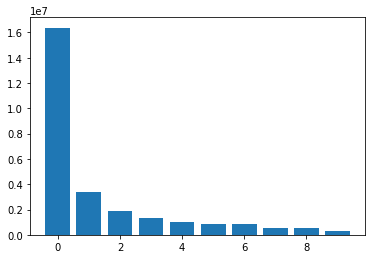

In [183]:
pca_comps = 10
pca = PCA(pca_comps)
pca.fit(X_train)
plt.bar(range(pca_comps), pca.explained_variance_)
sum(pca.explained_variance_ratio_)

In [75]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [76]:
np.count_nonzero(y_train)/len(y_train), np.count_nonzero(y_test)/len(y_test)

(0.37351308485329104, 0.07294117647058823)

In [77]:
Counter(y_train)

Counter({0: 790,
         3: 37,
         20: 9,
         1: 123,
         2: 69,
         7: 16,
         13: 13,
         11: 15,
         16: 11,
         4: 25,
         12: 14,
         5: 22,
         10: 15,
         8: 16,
         9: 15,
         19: 10,
         18: 10,
         17: 11,
         15: 11,
         14: 11,
         6: 18})

In [90]:
model_dt = tree.DecisionTreeClassifier()
tree_para = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10]}
grid_dt = GridSearchCV(estimator=model_dt, param_grid=tree_para, cv=5)
clf_dt = grid_dt.fit(X_train_pca, y_train)
print("tuned hyperparameters :(best parameters) ",clf_dt.best_params_)
print("accuracy :",clf_dt.best_score_)

tuned hyperparameters :(best parameters)  {'criterion': 'entropy', 'max_depth': 6}
accuracy : 0.6534945730597904


In [109]:
model_lr = LogisticRegression(solver='liblinear', max_iter=300)
lr_para = {"C":np.logspace(-2,2,5), "penalty":["l1","l2"]}
grid_lr = GridSearchCV(estimator=model_lr, param_grid=lr_para, cv=5)
clf_lr = grid_lr.fit(X_train_pca, y_train)

/home/koki/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/koki/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/koki/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/koki/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/koki/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the numbe

In [110]:
print("tuned hyperparameters :(best parameters) ",clf_lr.best_params_)
print("accuracy :",clf_lr.best_score_)

tuned hyperparameters :(best parameters)  {'C': 0.1, 'penalty': 'l1'}
accuracy : 0.6542474433778781


In [111]:
#clf_dt = tree.DecisionTreeClassifier(criterion='entropy', max_depth=4)
# clf_dt.fit(X_train, y_train)

In [112]:
# clf_lr = LogisticRegression(C=0.01, solver='liblinear', penalty = 'l1', max_iter=500)
# clf_lr.fit(X_train, y_train)

In [113]:
y_pred_dt = clf_dt.predict(X_test_pca)
y_pred_proba_dt = clf_dt.predict_proba(X_test_pca)

In [114]:
y_pred_lr = clf_lr.predict(X_test_pca)
y_pred_proba_lr = clf_lr.predict_proba(X_test_pca)

In [115]:
# sorted(sklearn.metrics.SCORERS.keys())

In [116]:
# cross_val_score(lr, X, y, cv=3, scoring='neg_log_loss')

In [117]:
metrics.f1_score(y_test, y_pred_dt, average='macro'), metrics.f1_score(y_test, y_pred_lr, average='macro')

(0.07876143831200011, 0.07381602485641653)

In [118]:
metrics.f1_score(y_test, y_pred_dt, average='micro'), metrics.f1_score(y_test, y_pred_lr, average='micro')

(0.8964705882352941, 0.9223529411764706)

In [119]:
metrics.log_loss(y_test, y_pred_proba_dt, labels=list(range(k+1))), \
metrics.log_loss(y_test, y_pred_proba_lr, labels=list(range(k+1)))

(1.4738389442253517, 0.701974071738471)

In [120]:
baseline = [[1/(k+1) for _ in range(k+1)] for _ in range(len(y_pred_proba_lr))]

In [121]:
vals = Counter(y_train)
baseline2 = [[vals[i]/sum(vals.values()) for i in range(k+1)] for _ in range(len(y_pred_proba_lr))]

In [122]:
len(baseline2)

425

In [123]:
metrics.log_loss(y_test, baseline, labels=list(range(k+1))), \
metrics.log_loss(y_test, baseline2, labels=list(range(k+1)))

(3.044522437723423, 0.738386734457992)

In [124]:
def plot_entropy(preds, title):
    vals = []
    for pr in preds:
        vals.append(entropy(pr))
    plt.hist(vals, 10, alpha=0.7)
    plt.title("Entropy distribution: {} \n Mean value: {}".format(title, np.round(np.mean(vals), 3)), \
              fontsize=13)
    plt.show()

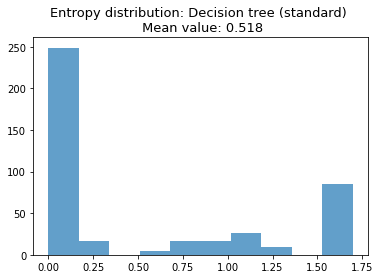

In [125]:
plot_entropy(y_pred_proba_dt, title="Decision tree (standard)")

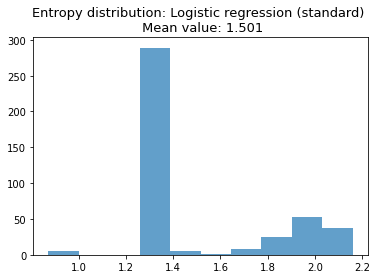

In [126]:
plot_entropy(y_pred_proba_lr, title='Logistic regression (standard)')

In [160]:
def get_embeddings_from_file(fname):
    embeddings = {}
    f = open(fname, 'r')
    for line in f.readlines():
        word = line.split('<->')[0] 
        vec = line.split('<->')[1]
        l = []
        for nr in vec.split():
            l.append(nr)
        embeddings[word] = np.array(l, dtype=np.float64)
    f.close()
    return embeddings

In [161]:
fname = "/home/koki/Desktop/Data/OutOfStock/embeddings.txt"
embeddings = get_embeddings_from_file(fname)

In [162]:
def create_dataset_emb(df, embeddings, top_ingredients):
    X = []
    y = []
    for _, row in df.iterrows():
        if row['Zulassungsinhaber'] not in embeddings:
            continue
        found = False
        for ws in row['wirkstoff']:
            if ws in top_ingredients:
                X.append(embeddings[row['Zulassungsinhaber']])
                y.append(top_ingredients.index(ws)+1)
                found = True
        if not found:
            X.append(embeddings[row['Zulassungsinhaber']])
            y.append(0)
    return X, y

In [163]:
X_emb, y_emb = create_dataset_emb(df, embeddings, top_k)
X_train_emb, y_train_emb = create_dataset_emb(df_train, embeddings, top_k)
X_test_emb, y_test_emb = create_dataset_emb(df_test, embeddings, top_k)

In [164]:
len(X_train_emb), len(X_test_emb)

(1257, 464)

In [165]:
X_train_emb = np.array(X_train_emb)
X_train_emb.shape

(1257, 10)

In [166]:
# pca_comps = 10
# pca = PCA(pca_comps)
# pca.fit(X_train)
# plt.bar(range(pca_comps), pca.explained_variance_)

In [167]:
model_dt_emb = tree.DecisionTreeClassifier()
tree_para = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10]}
grid_dt_emb = GridSearchCV(estimator=model_dt_emb, param_grid=tree_para, cv=5)
clf_dt_emb = grid_dt_emb.fit(X_train_emb, y_train_emb)
print("tuned hyperparameters :(best parameters) ",clf_dt_emb.best_params_)
print("accuracy :",clf_dt_emb.best_score_)

tuned hyperparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 4}
accuracy : 0.6507557073294125


In [168]:
model_lr_emb = LogisticRegression(solver='liblinear', max_iter=300)
lr_para = {"C":np.logspace(-2,2,5), "penalty":["l1","l2"]}
grid_lr_emb = GridSearchCV(estimator=model_lr_emb, param_grid=lr_para, cv=5)
clf_lr_emb = grid_lr_emb.fit(X_train_emb, y_train_emb)
print("tuned hyperparameters :(best parameters) ",clf_lr_emb.best_params_)
print("accuracy :",clf_lr_emb.best_score_)

tuned hyperparameters :(best parameters)  {'C': 1.0, 'penalty': 'l1'}
accuracy : 0.6531429836210713


In [185]:
entropy([0.01, 0.98, 0.01]), entropy([0.2, 0.5, 0.3])

(0.11190205689093088, 1.0296530140645737)

In [169]:
y_pred_emb_dt = clf_dt_emb.predict(X_test_emb)
y_pred_emb_dt_proba = clf_dt_emb.predict_proba(X_test_emb)

In [170]:
y_pred_emb_lr = clf_lr_emb.predict(X_test_emb)
y_pred_emb_lr_proba = clf_lr_emb.predict_proba(X_test_emb)

In [171]:
ye = np.eye(k+1)[y_test_emb]

In [172]:
metrics.log_loss(ye, y_pred_emb_dt_proba), metrics.log_loss(ye, y_pred_emb_lr_proba)

(1.0212902745725163, 0.613757145441929)

In [173]:
metrics.f1_score(y_test_emb, y_pred_emb_dt, average='macro'), \
metrics.f1_score(y_test_emb, y_pred_emb_lr, average='macro')

(0.06846240179573512, 0.07398444252376836)

In [174]:
metrics.f1_score(y_test_emb, y_pred_emb_dt, average='micro'), \
metrics.f1_score(y_test_emb, y_pred_emb_lr, average='micro')

(0.9202586206896551, 0.9224137931034483)

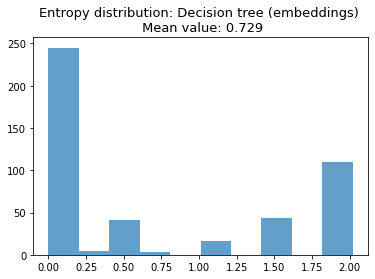

In [175]:
plot_entropy(y_pred_emb_dt_proba, title="Decision tree (embeddings)")

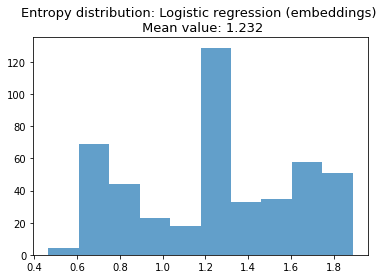

In [176]:
plot_entropy(y_pred_emb_lr_proba, title="Logistic regression (embeddings)")